In [1]:
## import the necessary packages## 
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## load the data ##
df=pd.read_csv(r"C:\Users\adnan\Downloads\customer _churn_using_logistic_regression\Churn_Modelling.csv")

In [3]:
## inspect the data ##
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
## understant the shape of the data ##
print(df.shape)
print(df.info())

(10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


In [5]:
## looking for missing values ##
print(df.isna().sum())
print(df.isna().sum().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
0


In [6]:
# examine the balance in the data to avoide bais 
print(df['Exited'].value_counts(normalize=True)*100)
print(df['Gender'].value_counts(normalize=True)*100)

Exited
0    79.63
1    20.37
Name: proportion, dtype: float64
Gender
Male      54.57
Female    45.43
Name: proportion, dtype: float64


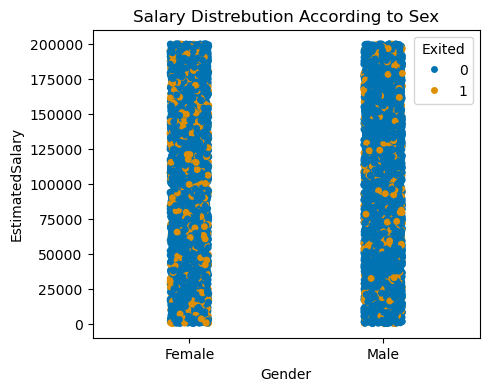

In [7]:
plt.figure(figsize=(5,4))
sns.stripplot(df,palette='colorblind',hue='Exited',x='Gender',y='EstimatedSalary')
plt.title('Salary Distrebution According to Sex')
plt.show()

In [8]:
## idintify the outliers ##
## subsiting the data for only numaric values 
df_num = df[['CreditScore','Tenure','Balance','EstimatedSalary']]
#  calculate the IQR
q1, q3 = np.percentile(df_num, [25, 75])
iqr = q3 - q1
outliers = df_num[(df_num< q1 - 1.5 * iqr) | (df_num > q3 + 1.5 * iqr)]

df_num_o =outliers.dropna(how='any')
print(df_num_o)


Empty DataFrame
Columns: [CreditScore, Tenure, Balance, EstimatedSalary]
Index: []


In [9]:
 
def find_outliers_iqr(s):
  q1, q3 = np.percentile(s, [25, 75])
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return s[(s < lower_bound) | (s > upper_bound)]

outliers_per_column = df_num.apply(find_outliers_iqr, axis=0)

for col in outliers_per_column:
  outliers = outliers_per_column[col].dropna()
  if not outliers.empty:
    print(f"Column '{col}' has outliers:\n{outliers}\n")

Column 'CreditScore' has outliers:
7       376
942     376
1193    363
1405    359
1631    350
1838    350
1962    358
2473    351
2579    365
8154    367
8723    350
8762    350
9210    382
9356    373
9624    350
Name: CreditScore, dtype: int64



#### since the only which has outliers is CreditScore and the number of outliers if we compare it the total number of rows in the data we can ignore it 


#### Feture engineering 


In [12]:
# select only the fetures which has the relevent outcome 
df_select = df.drop(['RowNumber','CustomerId','Surname','Gender'],axis=1)

df_select.head()

In [14]:
# print the uniqe vallues of the geographic col
df_select['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [15]:
# use dummy encoder for the catigorical variable 
df_select = pd.get_dummies(df_select, drop_first=True).astype(int)

In [16]:
df_select.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0,1,1,1,101348,1,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1
2,502,42,8,159660,3,1,0,113931,1,0,0
3,699,39,1,0,2,0,0,93826,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1


### Building the model

In [118]:
x = df_select.drop('Exited',axis=1)  
y = df_select['Exited']

In [120]:
## divded the data into traning and testing data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y ,random_state=42)

In [122]:
# building the model 
# building the model 
model = LogisticRegression(max_iter=2000)

# change the scale of the traning data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)  


x_test = scaler.transform(x_test)

In [124]:
# traning the model
model.fit(x_train,y_train)

LogisticRegression(max_iter=2000)

In [128]:
y_pred = model.predict(x_test)

In [130]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


In [132]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(f"cmm:\n {cm}")

cmm:
 [[2323   66]
 [ 493  118]]


In [134]:

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print(f"percision: {precision:.2f}")

percision: 0.64


In [136]:

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print(f"recall: {recall:.2f}")

recall: 0.19


In [140]:

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f"deg F1: {f1:.2f}")

deg F1: 0.30


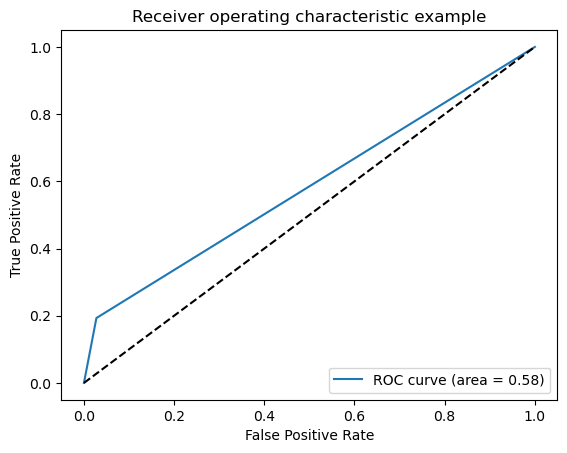

In [142]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


###  because the data is unbalance for the favoour of the false true negative we can impove the model performance by using upsampling for the data

In [95]:
# the model is poor we need to enhance it
from sklearn.utils import resample
# split the data
majority_indices = np.where(y_train == 0)[0]
minority_indices = np.where(y_train == 1)[0]

x_majority = x_train[majority_indices]
x_minority = x_train[minority_indices]

In [97]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [99]:
model = LogisticRegression(max_iter=2000)
model.fit(x_train_resampled, y_train_resampled)

LogisticRegression(max_iter=2000)

In [101]:
y_pred = model.predict(x_test)

In [103]:

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))


0.7236666666666667


In [105]:

from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred))


0.4007285974499089


In [107]:

from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred))

0.7201309328968903


In [109]:

from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred))


0.5149210064365126


In [113]:

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))


[[1731  658]
 [ 171  440]]


In [115]:

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7223509415426268
